In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import seaborn as sns

sns.set()

In [119]:
class Radar:

  def __init__(self):
    self.sd = 0.4
    self.cov = self.sd**2

  def get_cov(self):
    return self.cov

  def get_sd(self):
    return self.sd

  def get_position(self, state):
    return state + random.uniform(-self.sd, self.sd)


class KalmanFilter:

  def __init__(self, x_t0, u_t0, A, B, R, C, Q, covMatrix_t0):
    self.covMatrix = covMatrix_t0
    self.x_t = x_t0
    self.A = A
    self.B = B
    self.R = R
    self.C = C
    self.Q = Q

  def predict(self, u_t):
    self.x_t = self.A@self.x_t + self.B@u_t
    self.covMatrix = self.A@self.covMatrix@self.A.T + self.R

  def correct(self, z_t):
    out = np.linalg.inv(self.C@self.covMatrix@self.C.T + self.Q)
    k = self.covMatrix@self.C.T@out
    self.x_t = self.x_t + k@(z_t - self.C@self.x_t)
    self.covMatrix = self.covMatrix - k@self.C@self.covMatrix

  def get_state(self):
    return self.x_t, self.covMatrix


def predict_state(x_t, covMatrix, A, B, u_t, R):
  x_t =  A@x_t + B@u_t
  covMatrix = A@covMatrix@A.T + R
  return x_t, covMatrix

def plot_gaussians(states, covMatrices, color, legend):
  fig = plt.figure(figsize=(20,15), dpi=100)
  ax = fig.add_subplot(111, aspect='equal')

  for i in range(0, len(states)):
    if i == 0:
      x = np.linspace(states[i]-2, states[i]+2, 200)
      y = norm.pdf(x, states[i], np.sqrt(covMatrices[i]))
      ax.plot(x, y, color = color, label=legend)
    else:
      x = np.linspace(states[i]-2, states[i]+2, 200)
      y = norm.pdf(x, states[i], np.sqrt(covMatrices[i]))
      ax.plot(x, y, color = color)
  ax.legend()
  plt.show()

def plot_gaussians_kf(predict, cov_predict, color_predict, legend_predict,
                      sensor,  cov_sensor,  color_sensor,  legend_sensor,
                      correct, cov_correct, color_correct, legend_correct,
                      ):
  fig = plt.figure(figsize=(20,15), dpi=100)
  ax = fig.add_subplot(111, aspect='equal')

  for i in range(0, len(predict)):
    if i ==0:
      x = np.linspace(predict[i]-2, predict[i]+2, 200)
      y = norm.pdf(x, predict[i], np.sqrt(cov_predict[i]))
      ax.plot(x, y, color = color_predict, label=legend_predict)

      x = np.linspace(sensor[i]-2, sensor[i]+2, 200)
      y = norm.pdf(x, sensor[i], np.sqrt(cov_sensor[i]))
      ax.plot(x, y, color = color_sensor, label=legend_sensor)

      x = np.linspace(correct[i]-2, correct[i]+2, 200)
      y = norm.pdf(x, correct[i], np.sqrt(cov_correct[i]))
      ax.plot(x, y, color = color_correct, label=legend_correct)

    else:

      x = np.linspace(predict[i]-1, predict[i]+1, 200)
      y = norm.pdf(x, predict[i], np.sqrt(cov_predict[i]))
      ax.plot(x, y, color = color_predict)

      x = np.linspace(sensor[i]-2, sensor[i]+2, 200)
      y = norm.pdf(x, sensor[i], np.sqrt(cov_sensor[i]))
      ax.plot(x, y, color = color_sensor)

      x = np.linspace(correct[i]-2, correct[i]+2, 200)
      y = norm.pdf(x, correct[i], np.sqrt(cov_correct[i]))
      ax.plot(x, y, color = color_correct)
  ax.legend()
  plt.show()

def print_satates(states, covs):
  for i in range(0, len(states)):
    print(f'Satate {i}: {states[i]:.3f}  - SD: {np.sqrt(covs[i]):.3f}')


In [104]:
SIMULATION_TIME = 5
dt = 1

In [105]:
# Variable Initialization

x_t0 = np.array([[0], # initial state
                 [2]
                 ])

u_t0 = np.array([[0]])

covMatrix_t0 = np.array([[0, 0],  # inital noise covariance
                         [0, 0]
                          ])

R  = np.array([[0.25**2, 0], #Process noise
               [0, 0.15**2]
               ])

In [92]:
A  = np.array([[1, dt],
               [0,  1]
               ])
B = np.array([[(dt**2)/2],
              [dt]
              ])

Satate 0: 2.000  - SD: 0.250
Satate 1: 4.000  - SD: 0.384
Satate 2: 6.000  - SD: 0.548
Satate 3: 8.000  - SD: 0.752
Satate 4: 10.000  - SD: 0.994


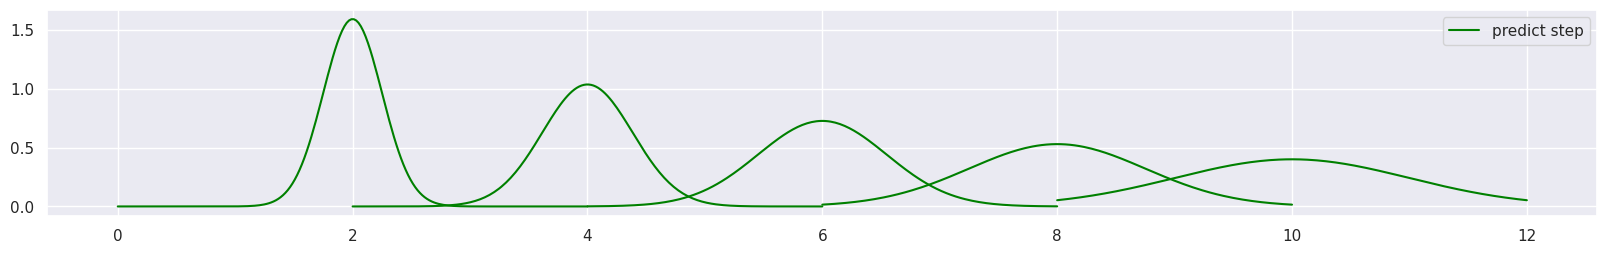

In [120]:
time = 0

states = []
covs = []

x_t = x_t0
covMatrix = covMatrix_t0

while time < SIMULATION_TIME:
  x_t, covMatrix = predict_state( x_t,
                                  covMatrix,
                                  A,
                                  B,
                                  u_t0,
                                  R
                                  )
  # Save states
  states.append(x_t[0][0])
  covs.append(covMatrix[0][0])
  time += dt

print_satates(states, covs)

plot_gaussians(states, covs, color = "green", legend = "predict step")

Satate 0: 1.744  - SD: 0.400
Satate 1: 4.049  - SD: 0.400
Satate 2: 6.040  - SD: 0.400
Satate 3: 7.983  - SD: 0.400
Satate 4: 9.870  - SD: 0.400


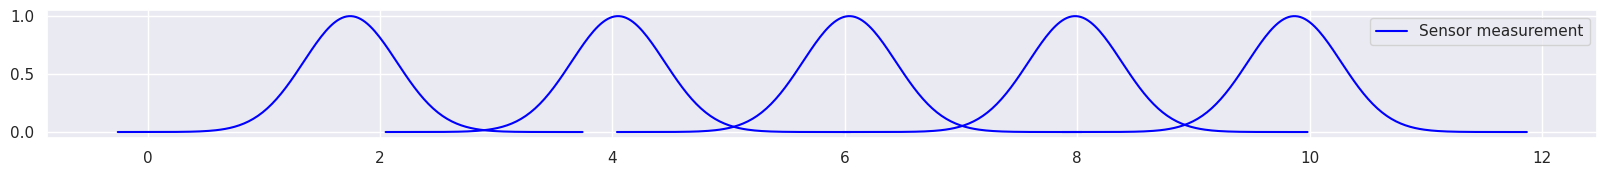

In [121]:
radar = Radar()

radar_positions = []
radar_covs = []

for state in states:
  x = radar.get_position(state)
  cov = radar.get_cov()
  radar_positions.append(x)
  radar_covs.append(cov)

print_satates(radar_positions, radar_covs)

plot_gaussians(radar_positions, radar_covs, color="blue", legend = "Sensor measurement")

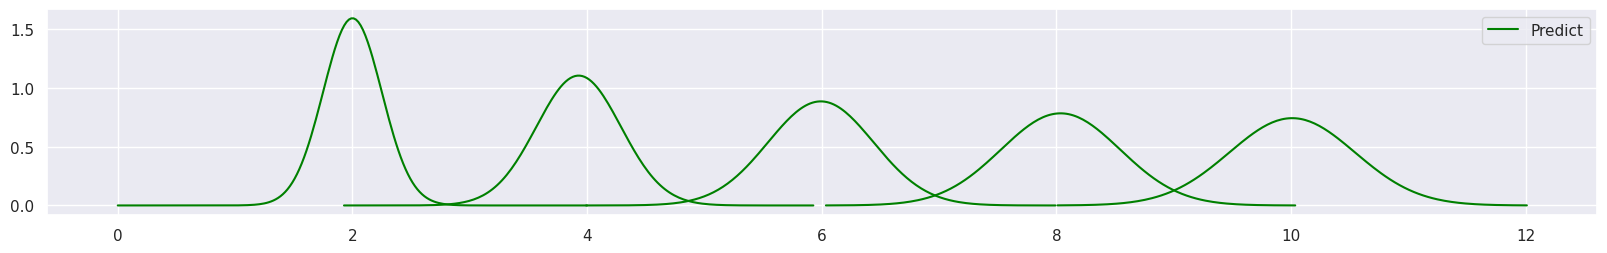

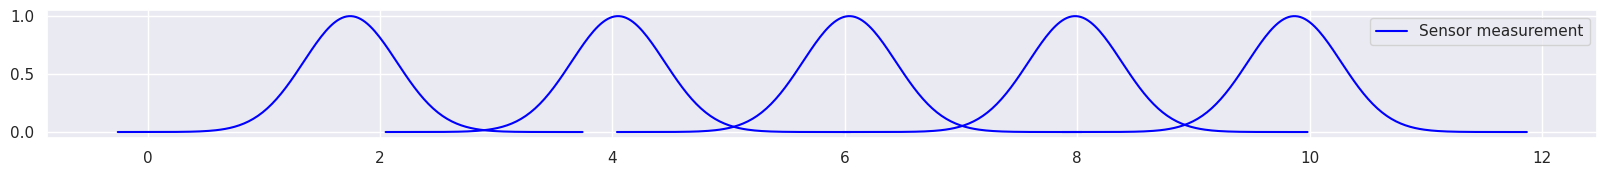

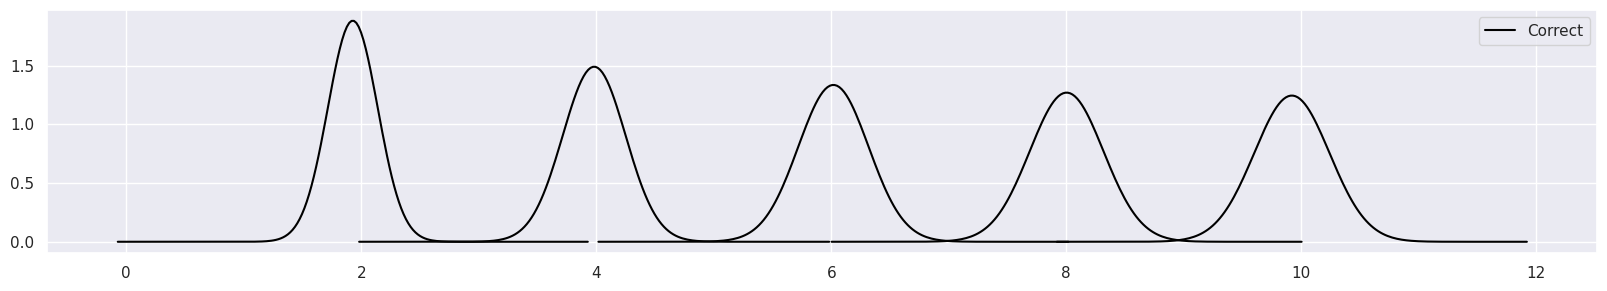

In [122]:
C = np.array([[1, 0]])
Q = np.array([[radar.get_cov()]])

time = 0

states_predict = []
covs_predict = []

states_correct = []
covs_correct = []

kalmanFilter = KalmanFilter(x_t0, u_t0, A, B, R, C, Q, covMatrix_t0)

while time < SIMULATION_TIME:
  kalmanFilter.predict(u_t0)

  x, cov = kalmanFilter.get_state()
  states_predict.append(x[0][0])
  covs_predict.append(cov[0][0])

  kalmanFilter.correct(radar_positions[time])

  x, cov = kalmanFilter.get_state()
  states_correct.append(x[0][0])
  covs_correct.append(cov[0][0])

  time += dt

plot_gaussians(states_predict, covs_predict, color="green", legend = 'Predict')
plot_gaussians(radar_positions, radar_covs, color="blue", legend = 'Sensor measurement')
plot_gaussians(states_correct, covs_correct, color="black", legend = 'Correct')

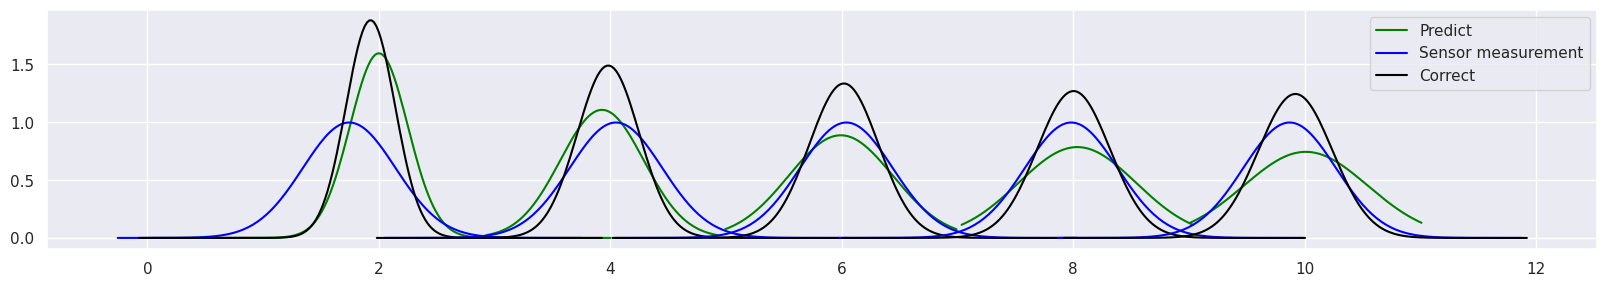

Satate 0: 1.928  - SD: 0.212
Satate 1: 3.982  - SD: 0.268
Satate 2: 6.018  - SD: 0.299
Satate 3: 8.003  - SD: 0.314
Satate 4: 9.920  - SD: 0.321


In [123]:
plot_gaussians_kf(states_predict, covs_predict, 'green', 'Predict',
                  radar_positions, radar_covs, 'blue', 'Sensor measurement',
                  states_correct, covs_correct, 'black', 'Correct')

print_satates(states_correct, covs_correct)